## Moments of size of $2$-Selmer groups

This notebook mainly contains code to verify Heath-Brown's results regarding the moments of $2$-Selmer groups. 
These results appeared in the paper: The size of Selmer groups for the congruent number problem, II Invent. math. 118, 331-370 (1994). 

Towards the end, the code verifies Poonen-Rains heuristics. 

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

pq_file = "three_mil_2selmer.parquet"
hb_columns = ['n','2selmer_rank', 'mod8']

table = pq.read_table(pq_file, columns=hb_columns)

# Convert the PyArrow Table to a Pandas DataFrame
df = table.to_pandas()
df['sofd'] = df['2selmer_rank'] - 2
df['size'] = 2 ** (df['sofd'])
odd_df =  df[df['mod8'].isin([1,3,5,7])].drop(columns=['2selmer_rank'])
odd_df['group'] = odd_df['mod8'].map(lambda x: '1_3' if x in [1, 3] else '5_7')

odd_df

,n,mod8,sofd,size,group
0,1,1,0,1,1_3
2,3,3,0,1,1_3
3,5,5,1,2,5_7
5,7,7,1,2,5_7
7,11,3,0,1,1_3
...,...,...,...,...,...
1823766,2999989,5,1,2,5_7
1823768,2999991,7,1,2,5_7
1823769,2999993,1,2,4,1_3
1823770,2999995,3,2,4,1_3


Computation of Empirical Moments

In [3]:
for k in [1, 2, 3, 4, 5]:
    moment = (odd_df['size'] ** k).mean()
    print(f"Empirical {k}-th moment of 2-Selmer rank: {moment:.5f}")

Empirical 1-th moment of 2-Selmer rank: 2.92396
Empirical 2-th moment of 2-Selmer rank: 14.86756
Empirical 3-th moment of 2-Selmer rank: 143.66827
Empirical 4-th moment of 2-Selmer rank: 2604.72468
Empirical 5-th moment of 2-Selmer rank: 80141.25410


**Conditional Moments by Residue mod 8**

This experiment helps test one of the most striking patterns predicted in Heath-Brown’s paper — that the behavior of the 2-Selmer rank depends statistically on the residue class mod 8, with some classes favoring even parity and higher ranks.

          mean   count
mod8                  
1     3.559437  303961
2     2.649251  303967
3     2.345209  303961
5     2.922269  303959
6     2.872280  303962
7     2.868941  303963


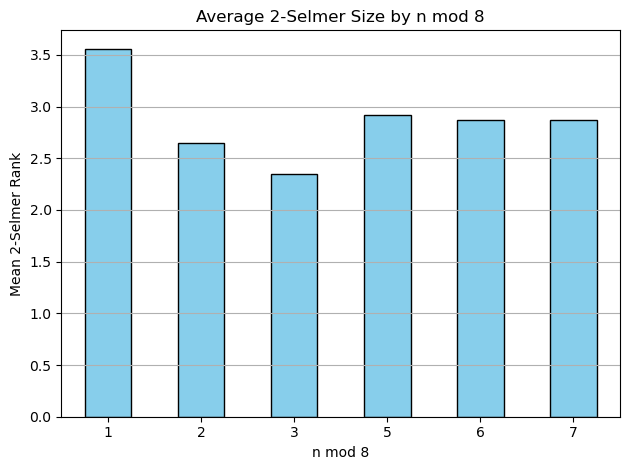

In [3]:
# Group by mod 8 residue and compute mean 2-Selmer rank and count
conditional_moments = df.groupby('mod8')['size'].agg(['mean', 'count']).sort_index()

# Display the table
print(conditional_moments)

# Plot: mean 2-Selmer rank by residue mod 8
conditional_moments['mean'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average 2-Selmer Size by n mod 8")
plt.xlabel("n mod 8")
plt.ylabel("Mean 2-Selmer Rank")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("conditional.jpeg")
plt.show()


Theoretical c_k values:
c_1 = 3
c_2 = 15
c_3 = 135

Comparison Table:
    mod8  k  EmpiricalMean  Theoretical_c_k  RelativeError
0      1  1       3.559437                3       0.186479
1      1  2      21.843151               15       0.456210
2      1  3     249.977892              135       0.851688
3      3  1       2.345209                3      -0.218264
4      3  2       9.561806               15      -0.362546
5      3  3      67.800382              135      -0.497775
6      5  1       2.922269                3      -0.025910
7      5  2      14.582348               15      -0.027843
8      5  3     142.576203              135       0.056120
9      7  1       2.868941                3      -0.043686
10     7  2      13.482930               15      -0.101138
11     7  3     114.318809              135      -0.153194


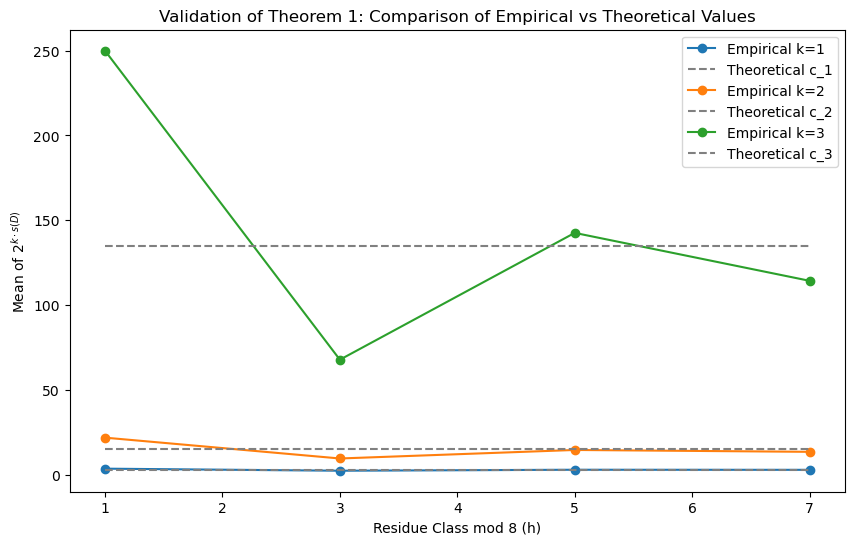

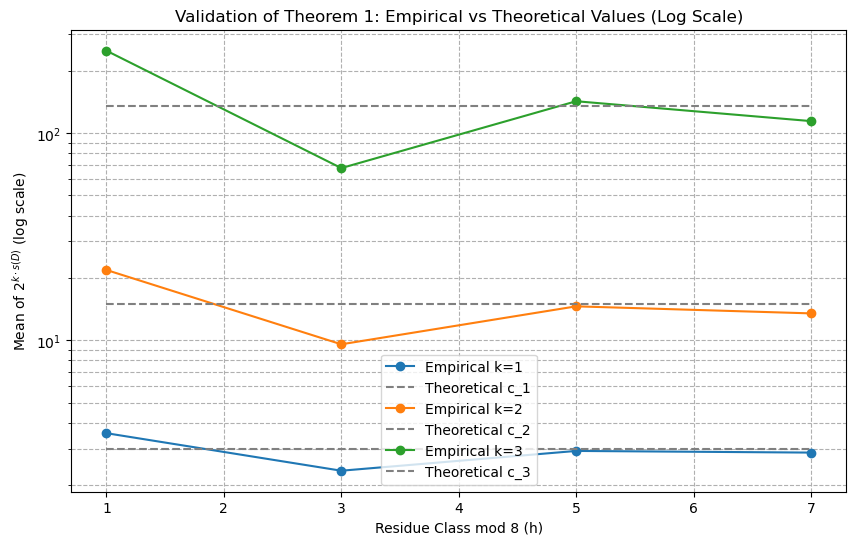

In [8]:
## Theorem 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def validate_theorem_1(odd_df, k_values=[1, 2, 3]):
    # Define theoretical c_k values
    c_k_values = {k: np.prod([1 + 2**j for j in range(1, k+1)]) for k in k_values}
    print("Theoretical c_k values:")
    for k, val in c_k_values.items():
        print(f"c_{k} = {val}")

    # Prepare comparison table
    results = []

    for h in [1, 3, 5, 7]:
        subset = odd_df[odd_df['mod8'] == h]
        size_h = len(subset)

        if size_h == 0:
            print(f"No data for residue class {h}. Skipping.")
            continue

        for k in k_values:
            empirical_sum = (2 ** (k * subset['sofd'])).sum()
            empirical_mean = empirical_sum / size_h
            theoretical_c_k = c_k_values[k]
            relative_error = (empirical_mean - theoretical_c_k) / theoretical_c_k

            results.append({
                'mod8': h,
                'k': k,
                'EmpiricalMean': empirical_mean,
                'Theoretical_c_k': theoretical_c_k,
                'RelativeError': relative_error
            })

    result_df = pd.DataFrame(results)
    print("\nComparison Table:")
    print(result_df)

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    for k in k_values:
        df_k = result_df[result_df['k'] == k]
        ax.plot(df_k['mod8'], df_k['EmpiricalMean'], 'o-', label=f'Empirical k={k}')
        ax.hlines(c_k_values[k], xmin=min(df_k['mod8']), xmax=max(df_k['mod8']),
                  colors='gray', linestyles='--', label=f'Theoretical c_{k}')

    ax.set_xlabel("Residue Class mod 8 (h)")
    ax.set_ylabel("Mean of $2^{k \cdot s(D)}$")
    ax.set_title("Validation of Theorem 1: Comparison of Empirical vs Theoretical Values")
    ax.legend()
    plt.show()

    return result_df



def plot_theorem1_logscale(result_df, c_k_values):
    fig, ax = plt.subplots(figsize=(10, 6))

    for k in sorted(result_df['k'].unique()):
        df_k = result_df[result_df['k'] == k]
        ax.plot(df_k['mod8'], df_k['EmpiricalMean'], 'o-', label=f'Empirical k={k}')
        ax.hlines(c_k_values[k], xmin=df_k['mod8'].min(), xmax=df_k['mod8'].max(),
                  colors='gray', linestyles='--', label=f'Theoretical c_{k}')

    ax.set_xlabel("Residue Class mod 8 (h)")
    ax.set_ylabel("Mean of $2^{k \cdot s(D)}$ (log scale)")
    ax.set_yscale("log")
    ax.set_title("Validation of Theorem 1: Empirical vs Theoretical Values (Log Scale)")
    ax.legend()
    ax.grid(True, which="both", linestyle="--")
    plt.savefig("thm1log.jpeg")
    plt.show()


result_df = validate_theorem_1(odd_df, k_values=[1, 2, 3])
c_k_values = {k: np.prod([1 + 2**j for j in range(1, k+1)]) for k in [1, 2, 3]}

plot_theorem1_logscale(result_df, c_k_values)

In [2]:
# The o_k(X) error term in Theorem 1. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Theoretical log factor from remark
def log_factor(k, X):
    return (np.log(np.log(X)) ** (4**k)) / (np.log(X) ** (1 / (4**k)))

def compute_ck(k):
    return np.prod([1 + 2**j for j in range(1, k + 1)])

def error_term_experiment(odd_df, h_values=[1, 3, 5, 7], k_values=[1, 2], X_cutoffs=None):
    if X_cutoffs is None:
        # Ensure X_cutoffs are sorted
        X_cutoffs = sorted(odd_df['n'].quantile(np.linspace(0.1, 1.0, 10)).astype(int).unique())

    result_rows = []
    
    for h in h_values:
        for k in k_values:
            c_k = compute_ck(k)
            for X in X_cutoffs:
                subset = odd_df[(odd_df['mod8'] == h) & (odd_df['n'] <= X)]
                count = len(subset)

                if count == 0:
                    continue

                empirical_sum = (2 ** (k * subset['sofd'])).sum()
                theoretical_sum = c_k * count
                delta = abs(empirical_sum - theoretical_sum)

                # Normalized error according to remark's formula
                lf = log_factor(k, X)
                norm_error = delta / (X * lf)

                result_rows.append({
                    'h': h,
                    'k': k,
                    'X': X,
                    'Delta': delta,
                    'Count': count,
                    'LogFactor': lf,
                    'NormalizedError': norm_error
                })

    return pd.DataFrame(result_rows)

def plot_normalized_error(df):
    plt.figure(figsize=(10, 6))
    for k in sorted(df['k'].unique()):
        df_k = df[df['k'] == k]
        # Plot each h separately
        for h in sorted(df_k['h'].unique()):
            df_h = df_k[df_k['h'] == h]
            plt.plot(df_h['X'], df_h['NormalizedError'], marker='o', label=f'k={k}, h={h}')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("X (log scale)")
    plt.ylabel("Normalized Error (log scale)")
    plt.title("Normalized Error vs X for Theorem 1 (log–log plot)")
    plt.legend()
    plt.savefig("error_term.jpeg")
    plt.grid(True, which="both", linestyle="--", alpha=0.7)
    plt.show()


    h  k        X   Delta   Count     LogFactor  NormalizedError
0   1  1   299999   13551   30393  2.190049e+01     2.062518e-03
1   1  1   600000   29110   60787  2.349276e+01     2.065176e-03
2   1  1   899988   45795   91188  2.441788e+01     2.083883e-03
3   1  1  1199993   63021  121584  2.507136e+01     2.094733e-03
4   1  1  1499982   80099  151976  2.557648e+01     2.087855e-03
.. .. ..      ...     ...     ...           ...              ...
75  7  2  1799970  355613  182383  5.560993e+06     3.552712e-08
76  7  2  2099985  384907  212777  5.922999e+06     3.094553e-08
77  7  2  2399984  404749  243179  6.250936e+06     2.697941e-08
78  7  2  2699984  433258  273578  6.551589e+06     2.449282e-08
79  7  2  2999999  461133  303963  6.829819e+06     2.250587e-08

[80 rows x 7 columns]


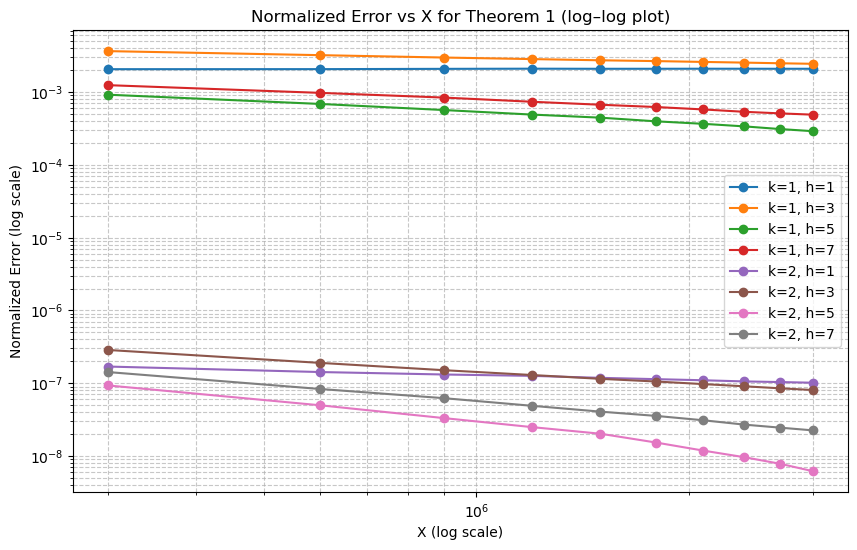

In [3]:
# Run the experiment
result_df = error_term_experiment(odd_df, h_values=[1, 3, 5, 7], k_values=[1, 2])

# Inspect first few results
print(result_df)
result_df.to_csv("loglogx_data.csv")

# Plot results
plot_normalized_error(result_df)


**The empirical PMF (probability mass function) of the 2-Selmer rank distribution**

In [15]:
# Compute empirical PMF
empirical_pmf = df['2selmer_rank'].value_counts(normalize=True).sort_index()
print("Empirical PMF of 2-Selmer Rank:")
print(empirical_pmf)

Empirical PMF of 2-Selmer Rank:
2selmer_rank
2    0.240650
3    0.429020
4    0.247179
5    0.070227
6    0.012141
7    0.000752
8    0.000032
Name: proportion, dtype: float64


**S2r	Poonen–Rains Probability**

0	   0.2097
1	   0.4194
2	   0.2796
3	   0.0787
4	   0.0121

Plotting Empirical vs. Theoretical PMF

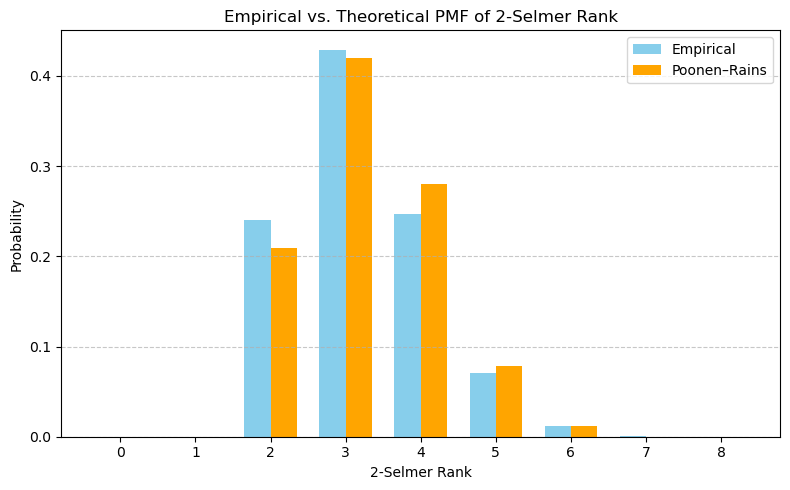

In [16]:
# Truncate to common support (up to 4 or 5 is usually enough)
max_rank = max(empirical_pmf.index.max(), 4)
ranks = list(range(0, max_rank + 1))

# Fill in missing empirical probabilities with 0
empirical_probs = [empirical_pmf.get(r, 0) for r in ranks]

# Theoretical Poonen–Rains probabilities (normalized for first 5 ranks)
poonen_rains_pmf = {
    2: 0.2097,
    3: 0.4194,
    4: 0.2796,
    5: 0.0787,
    6: 0.0121
}
theoretical_probs = [poonen_rains_pmf.get(r, 0) for r in ranks]

# Plot
plt.figure(figsize=(8, 5))
bar_width = 0.35
x = range(len(ranks))

plt.bar([i - bar_width/2 for i in x], empirical_probs, width=bar_width, label="Empirical", color='skyblue')
plt.bar([i + bar_width/2 for i in x], theoretical_probs, width=bar_width, label="Poonen–Rains", color='orange')

plt.xticks(x, ranks)
plt.xlabel("2-Selmer Rank")
plt.ylabel("Probability")
plt.title("Empirical vs. Theoretical PMF of 2-Selmer Rank")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Total Variation Distance (TVD)**

To quantify the match, use the total variation distance between the empirical and theoretical distributions: A small TVD (e.g., < 0.1) suggests strong agreement with theory.

In [17]:
tvd = 0.5 * sum(abs(emp - theo) for emp, theo in zip(empirical_probs, theoretical_probs))
print(f"Total Variation Distance (TVD): {tvd:.4f}")

Total Variation Distance (TVD): 0.0411


In [18]:
#import pandas as pd

# Load your empirical data
#df = pd.read_csv("your_data.csv")  # Ensure it has 'selmer2_rank' column

# Step 1: Compute empirical moments
empirical_moments = {}
#for k in range(1, 5):
#    empirical_moments[k] = ((df['2selmer_rank']-2) ** k).mean()

#df['size'] = 2**(df['2selmer_rank']-2)
for k in range(1, 5):
    empirical_moments[k] = ((df['size']) ** k).mean()

# Step 2: Define Poonen–Rains PMF (truncated at rank 5)
poonen_rains_pmf = {
    0: 0.2097,
    1: 0.4194,
    2: 0.2796,
    3: 0.0787,
    4: 0.0121,
    5: 0.0005
}

# Step 3: Compute theoretical moments
theoretical_moments = {}
for k in range(1, 5):
    moment = sum((2 ** (r*k)) * prob for r, prob in poonen_rains_pmf.items())
    theoretical_moments[k] = moment

# Step 4: Print comparison
print(f"{'Moment':<10}{'Empirical':>15}{'Theoretical':>15}")
for k in range(1, 5):
    print(f"{'E[r^'+str(k)+']':<10}{empirical_moments[k]:>15.6f}{theoretical_moments[k]:>15.6f}")

#df

Moment          Empirical    Theoretical
E[r^1]           2.869564       3.006100
E[r^2]          14.414192      15.007300
E[r^3]         138.146738     127.699300
E[r^4]        2475.496656    1718.126500


The plot of the abvove comparison

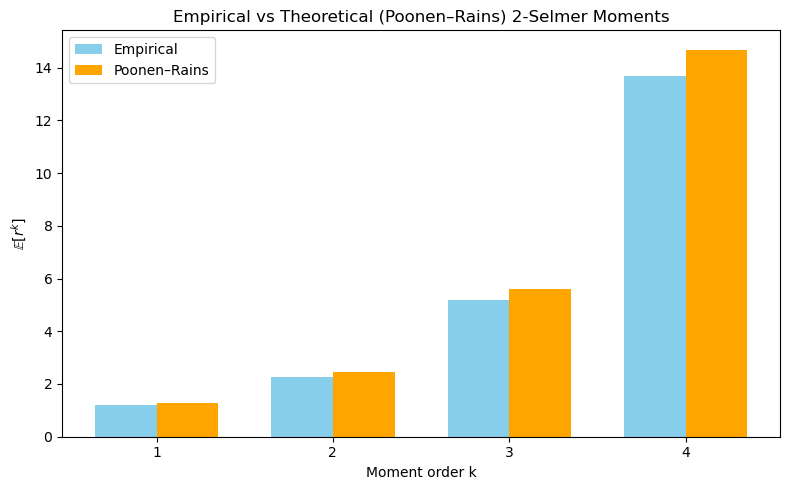

In [19]:
# Empirical moments
empirical_moments = [ ((df['2selmer_rank']-2) ** k).mean() for k in range(1, 5) ]

# Theoretical (Poonen–Rains) PMF
pr_pmf = {0: 0.2097, 1: 0.4194, 2: 0.2796, 3: 0.0787, 4: 0.0121, 5: 0.0005}
theoretical_moments = [ sum((r**k) * prob for r, prob in pr_pmf.items()) for k in range(1, 5) ]

# Plotting
ks = np.arange(1, 5)
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(ks - width/2, empirical_moments, width, label='Empirical', color='skyblue')
ax.bar(ks + width/2, theoretical_moments, width, label='Poonen–Rains', color='orange')
ax.set_xlabel("Moment order k")
ax.set_ylabel(r"$\mathbb{E}[r^k]$")
ax.set_title("Empirical vs Theoretical (Poonen–Rains) 2-Selmer Moments")
ax.set_xticks(ks)
ax.legend()
plt.tight_layout()
plt.show()


Empirical Moments vs. number growth

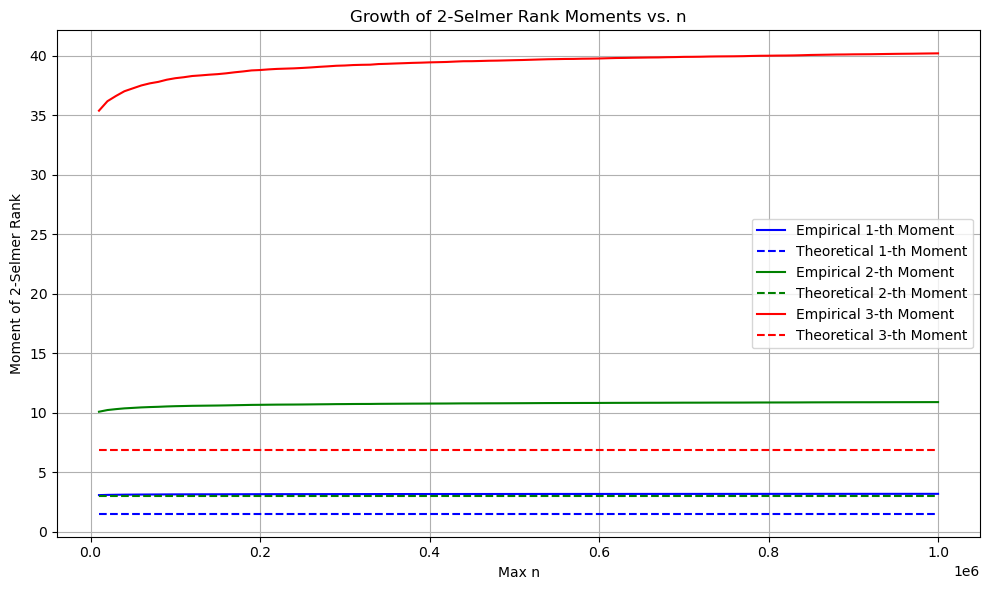

In [20]:
import numpy as np

# Define sample points X (increasing values of n)
X_values = np.linspace(10000, 1_000_000, 100, dtype=int)

# Choose which moments to compute
moment_orders = [1, 2, 3]
moment_data = {k: [] for k in moment_orders}

# Compute moments up to each X
for X in X_values:
    subset = df[df['n'] <= X]
    for k in moment_orders:
        moment_k = ((subset['2selmer_rank']) ** k).mean()
        moment_data[k].append(moment_k)
    #print(moment_data[1])

# Plot each moment
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
theoretical_moments = {
    1: 1.5,
    2: 3.0,
    3: 6.875  # From Poonen–Rains model for 2-Selmer RECHECK VALUES
}

for i, k in enumerate(moment_orders):
    plt.plot(X_values, moment_data[k], label=f"Empirical {k}-th Moment", color=colors[i])
    if k in theoretical_moments:
        plt.hlines(theoretical_moments[k], X_values[0], X_values[-1], 
                   color=colors[i], linestyle='--', label=f"Theoretical {k}-th Moment")

plt.title("Growth of 2-Selmer Rank Moments vs. n")
plt.xlabel("Max n")
plt.ylabel("Moment of 2-Selmer Rank")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Log log plot of the Moment growth

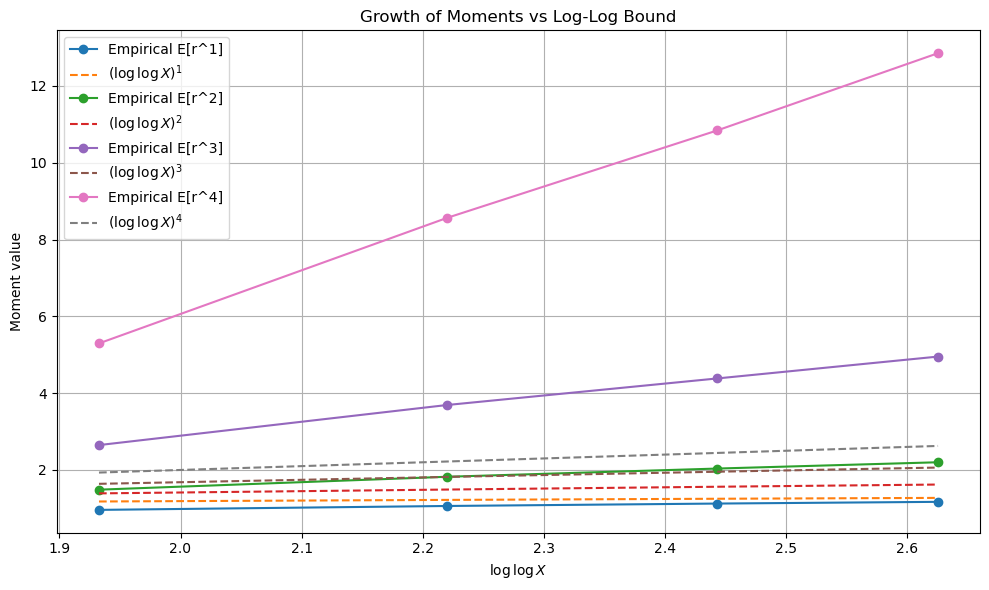

In [24]:
# Binning thresholds
X_vals = [10**3, 10**4, 10**5, 10**6]

# Moments to track
#moment_k = 1  # Can loop over 1 to 4
plt.figure(figsize=(10, 6))
for k in range(1,5):
    moment_vals = []
    #loglog_X = []
    for X in X_vals:
        sub = df[df['n'] <= X]
        moment = ((sub['2selmer_rank']-2) ** k).mean()
        moment_vals.append(moment)
    plt.plot(np.log(np.log(X_vals)), moment_vals, 'o-', label=f'Empirical E[r^{k}]')
    plt.plot(np.log(np.log(X_vals)), [np.log(np.log(X))**(k/4) for X in X_vals], '--', label=fr'$(\log\log X)^{k}$')


# Plotting
plt.xlabel(r'$\log\log X$')
plt.ylabel(r'Moment value')
plt.title('Growth of Moments vs Log-Log Bound')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

